<a href="https://colab.research.google.com/github/karol10542/MyRepo/blob/main/_projektDeep_learning_helicopter_passenger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#do kopiowania plikow
import shutil
import plotly.graph_objects as go

from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
#do augumentacji danych
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.callbacks import TensorBoard
#from tensorflow.keras.applications import VGG19

np.set_printoptions(precision=6, suppress=True)

In [ ]:

#wypakowanie
!unzip -q flying-vehicles.zip

In [52]:
!rm -rf ./images #czyscimy katalog roboczy

In [53]:
 base_dir = '/content/data/planes' #bazowy katalog z danymi
 #sprawdzimy sobie ile mamy danych do poszczegolnych grup
 raw_no_of_files = {}
 classes = ['drone','fighter-jet','helicopter','missile','passenger-plane','rocket']
 for dir in classes:
   raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir,dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [55]:
data_dir = './images' #katalog do naszych danych

if not os.path.exists(data_dir): #jesli taki katalog nie istnieje to go utowrzymy 
  os.mkdir(data_dir)

train_dir = os.path.join(data_dir,'train') # tworzymy katalog zbioru treningowego
valid_dir = os.path.join(data_dir,'valid') #tworzymy katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir,'test') #tworzymy katalog zbioru testowego
#dalej tworzymy dla dwoch obiektow foldery treningowe, valid i testowe
train_helicopter_dir = os.path.join(train_dir,'helicopter')
train_passenger_dir = os.path.join(train_dir,'passenger')

valid_helicopter_dir = os.path.join(valid_dir,'helicopter')
valid_passenger_dir = os.path.join(valid_dir,'passenger')

test_helicopter_dir = os.path.join(test_dir,'helicopter')
test_passenger_dir = os.path.join(test_dir,'passenger')
#petla ktora to utworzy
for directory in (train_dir,valid_dir,test_dir):
  if not os.path.exists(directory):
    os.mkdir(directory)
dirs = [train_helicopter_dir, train_passenger_dir,valid_helicopter_dir,valid_passenger_dir,test_helicopter_dir,test_passenger_dir]

for dir in dirs:
  if not os.path.exists(dir):
    os.mkdir(dir)
    

In [62]:
#tworzymy nazwy naszych plikow  // przypisujemy wylistowanie  katalogu  z kat bazowego //potrzebne do kopiowania
helicopter_fnames = os.listdir(os.path.join(base_dir,'helicopter'))
passenger_fnames = os.listdir(os.path.join(base_dir,'passenger-plane'))
#przypisanie zwalidowanych plikow, aby mialy dokladnie takie a nie inne nazwy
helicopter_fnames = [fname for fname in helicopter_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]
passanger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg','png','jpeg']]

In [63]:
#okreslamy rozmiar danych do naszego modelu  // wybieramy minimalna tych klas
size = min(len(helicopter_fnames),len(passenger_fnames))
#wybieramy 70proc do treningu 20proc do valid i reszte do testow
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size
#indexy ktore ulatwia kopiowanie plikow
train_idx = train_size
valid_idx = train_size + valid_size 
test_idx = train_size + valid_size + test_size 


In [65]:
#kopiujemy zdj helicop 
for i, fname in enumerate(helicopter_fnames):
  if i <= train_idx:
    src=os.path.join(base_dir,'helicopter',fname)
    dst = os.path.join(train_helicopter_dir,fname)
    shutil.copyfile(src,dst)
  elif train_idx < i <=valid_idx:
      src = os.path.join(base_dir,'helicopter',fname)
      dst = os.path.join(valid_helicopter_dir,fname)
      shutil.copyfile(src,dst)
  elif valid_idx < i < test_idx:
      src = os.path.join(base_dir,'helicopter',fname)
      dst = os.path.join(test_helicopter_dir,fname)
      shutil.copyfile(src,dst)


for i, fname in enumerate(passenger_fnames):
  if i <= train_idx:
    src=os.path.join(base_dir,'passenger-plane',fname)
    dst = os.path.join(train_passenger_dir,fname)
    shutil.copyfile(src,dst)
  elif train_idx <= i <valid_idx:
    src = os.path.join(base_dir,'passenger-plane',fname)
    dst = os.path.join(valid_passenger_dir,fname)
    shutil.copyfile(src,dst)
  elif valid_idx < i < test_idx:
    src = os.path.join(base_dir,'passenger-plane',fname)
    dst = os.path.join(test_passenger_dir,fname)
    shutil.copyfile(src,dst)

print('helicopter - zbior treningowy',len(os.listdir(train_helicopter_dir)))
print('helicopter - zbior walidacyjny',len(os.listdir(valid_helicopter_dir)))
print('helicopter - zbior testowy',len(os.listdir(test_helicopter_dir)))

print('passenger - zbior treningowy',len(os.listdir(train_passenger_dir)))
print('passenger - zbior walidacyjny',len(os.listdir(valid_passenger_dir)))
print('passenger - zbior testowy',len(os.listdir(test_passenger_dir)))

helicopter - zbior treningowy 952
helicopter - zbior walidacyjny 271
helicopter - zbior testowy 136
passenger - zbior treningowy 952
passenger - zbior walidacyjny 270
passenger - zbior testowy 136


(-0.5, 403.5, 235.5, -0.5)

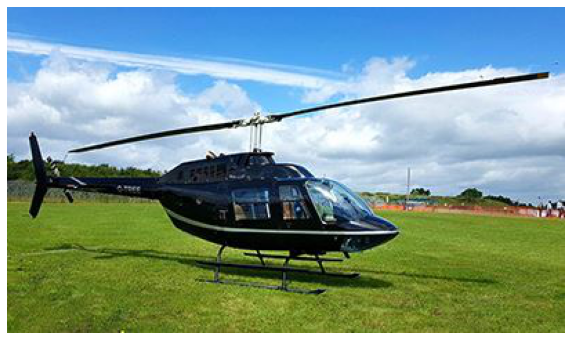

In [71]:
#wizualizacja naszych danych => helicopter
idx = 552 #@param {type:'slider',min:0,max:919}
names_mapping = dict(enumerate(helicopter_fnames))
img_path = os.path.join(train_helicopter_dir,names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 299.5, 211.5, -0.5)

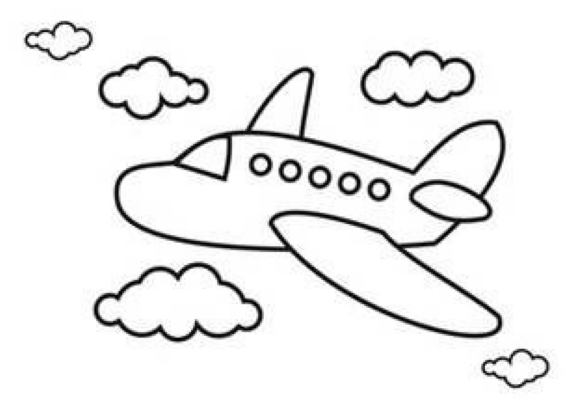

In [74]:
#wizualizacja naszych danych => Samolot 
idx = 640 #@param {type:'slider',min:0,max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir,names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [75]:
#augmentacja danych siec bedzie mogla sie o wiele bardziej nauczyc
#
train_datagen = ImageDataGenerator(
    rotation_range= 40, #zakres kata losowo zostanie ustawiony obrazek
    rescale = 1./255.,
    width_shift_range=0.2, #pion przeksztl obrazka
    height_shift_range=0.2, #pozi przeksztl obrazka
    shear_range=0.2, #zares losowego przecinania obrazka
    zoom_range = 0.2, #zakres losow przyblioznego obrazka
    horizontal_flip = True, #rand odbicie polowy obrazka w plaszczyznie poziom
    fill_mode ='nearest' #strategia wypelninia nowo utworzonych piskenli ktore moga powstac w wynikiu przeksztalcen
)

#przeskalowujemy wszystkie obrazy o wspolczynnik 1/255, standaryzujemy cechy do modelu
valid_datagen= ImageDataGenerator(rescale=1./255.)
#pozwoli zaladowac pliki bezposrednio do katalogu, gdzie mamy dane treningowe
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                    target_size=(150,150), #docelowy rozm zdj
                                                    batch_size = 32, #rozmiar wsadu
                                                    class_mode='binary') # nasz problem jst binarny
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                         target_size=(150,150),
                                                         batch_size=32,
                                                         class_mode='binary')

Found 1894 images belonging to 2 classes.
Found 539 images belonging to 2 classes.


In [81]:
# dla przykladu
def disp_img(directory,idx):
  fnames = [os.path.join(directory,fname) for fname in os.listdir(directory)]
  img_path=fnames[idx]
  img=image.load_img(img_path,target_size=(150,150))

  x = image.img_to_array(img)
  x = x.reshape((1,)+ x.shape)

  i = 1
  plt.figure(figsize=(20,14))
  for batch in train_datagen.flow(x,batch_size=1):
    plt.subplot(3,4,i)
    plt.grid(False) #szkielet siatki
    imgplot = plt.imshow(image.array_to_img(batch[0]))
    i+=1
    if i % 13 == 0:
      break

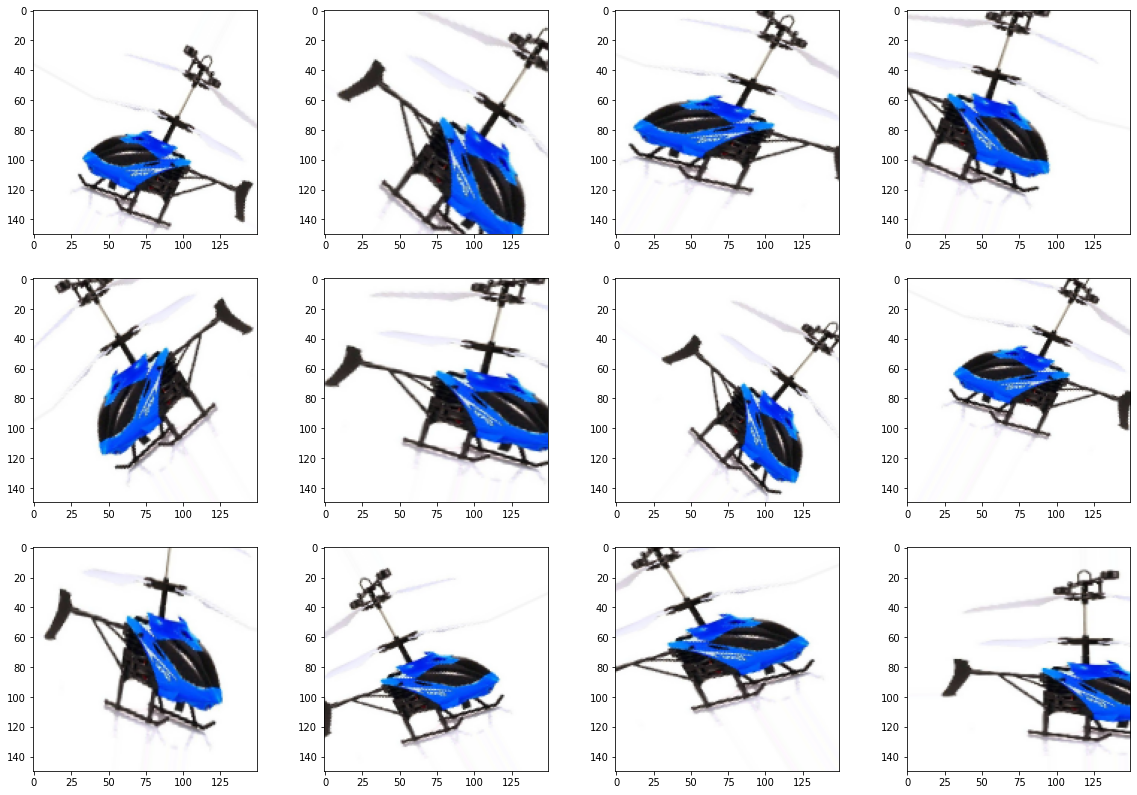

In [83]:
#wizualizacja naszych danych augment 
idx = 162 #@param {type:'slider',min:0,max:919}
disp_img(train_helicopter_dir,idx)

Budowa modelu

In [85]:
#tworzymy model uzywamy rozmiaru rozmiar jadra 3,3 typowy rozm, activ relu i rozmiar danych 150,150 - wystandaryzowan, i 3 - kolorowe zdj
model = Sequential()
model.add(layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=(150,150,3))) #uzywamy wartswy Conv2D warstwa ktora pozwoli wykonac operacje splotu, uzywamy filtry i redukujemy odpowiednio zdj
model.add(layers.MaxPooling2D(pool_size=(2,2))) #maxpooling2d okienko ktore wyciaga max wartosc pixela, i skacze co dwa okienka
model.add(layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu')) #zwiekszamy liczbe filtorw
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2,2)))
model.add(layers.Flatten()) #splaszczamy nasze dane
model.add(layers.Dense(units=512,activation='relu')) #teraz tworzymy warstwe gesto polaczona 512 neuronow
model.add(layers.Dense(units=1,activation='sigmoid')) # a na koniec zwaraca jeden neuron i funkcja sigmoid, bo chcemy zwrocone prawdop
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 15, 15, 128)      

In [86]:
#teraz kompilujemy nasz model, optimzer rmsprop loss - binary poniewaz jest to problem binarny
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [87]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [88]:
#trenujemy model z uzyciem fit_generator co pozwoli bardziej dopasowac generator,
batch_size = 32 #rozmiar wsadu
steps_per_epoch = train_size //batch_size 
validation_steps = valid_size //batch_size

history= model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=80,
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/80
29/29 [==============================] - 25s 844ms/step - loss: 0.7050 - accuracy: 0.4667 - val_loss: 0.6840 - val_accuracy: 0.6289
Epoch 2/80
29/29 [==============================] - 24s 836ms/step - loss: 0.6872 - accuracy: 0.5577 - val_loss: 0.6606 - val_accuracy: 0.6523
Epoch 3/80
29/29 [==============================] - 22s 769ms/step - loss: 0.6680 - accuracy: 0.6056 - val_loss: 0.6203 - val_accuracy: 0.6797
Epoch 4/80
29/29 [==============================] - 23s 809ms/step - loss: 0.6379 - accuracy: 0.6440 - val_loss: 0.5993 - val_accuracy: 0.6914
Epoch 5/80
29/29 [==============================] - 25s 820ms/step - loss: 0.6210 - accuracy: 0.6641 - val_loss: 0.5892 - val_accuracy: 0.6758
Epoch 6/80
29/29 [==============================] - 24s 835ms/step - loss: 0.6112 - accuracy: 0.6596 - val_loss: 0.5970 - val_accuracy: 0.7227
Epoch 7/80
29/29 [==============================] - 23s 793ms/step - loss: 0.6276 - accuracy: 0.6529 - val_loss: 0.5865 - val_accuracy: 0.6797

In [ ]:
%load_ext tensorboard

In [ ]:
!tensorboard dev upload --logdir logs

In [89]:
#tworzymy funkcje ktora za pomoca biblioteki plotly wyswietli nam wykres accuracy oraz val accuracy,dokladnosc itp
def plot_hist(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['accuracy'],name='accuracy',mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['val_accuracy'],name='val_accuracy',mode='markers+lines'))
  fig.update_layout(width=1000,height=500,title='accuracy vs val accuracy',xaxis_title='epoki',yaxis_title='accuracy')
  fig.show()

  fig = go.Figure()
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['loss'],name='accuracy',mode='markers+lines'))
  fig.add_trace(go.Scatter(x=hist['epoch'],y=hist['val_loss'],name='val_loss',mode='markers+lines'))
  fig.update_layout(width=1000,height=500,title='loss vs val loss',xaxis_title='epoki',yaxis_title='loss')
  fig.show()
plot_hist(history)

In [ ]:
#ocena modelu na zbiorze testowym

In [90]:
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    batch_size=1,
    class_mode='binary',
    shuffle=False #aby nie przetasowac danych
)
# predyckcja zwraca prawd przynaleznosci do danych klas
y_prob = model.predict_generator(test_generator,test_generator.samples)
y_prob = y_prob.ravel()
y_prob 

Found 272 images belonging to 2 classes.


/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning:

`Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.



array([0.002936, 0.147967, 0.413653, 0.250993, 0.076517, 0.031856,
       0.003398, 0.518508, 0.005387, 0.143503, 0.012919, 0.950237,
       0.230252, 0.07465 , 0.37392 , 0.008599, 0.041881, 0.08623 ,
       0.382175, 0.454878, 0.086172, 0.011244, 0.075899, 0.022976,
       0.038946, 0.006147, 0.243565, 0.692592, 0.006767, 0.19031 ,
       0.07247 , 0.11805 , 0.463904, 0.040586, 0.441503, 0.312509,
       0.031725, 0.125539, 0.452228, 0.672038, 0.613777, 0.420514,
       0.037231, 0.31918 , 0.02798 , 0.410852, 0.257773, 0.008583,
       0.108738, 0.001275, 0.019991, 0.01525 , 0.220563, 0.005109,
       0.197074, 0.25379 , 0.012463, 0.261311, 0.001817, 0.287241,
       0.121626, 0.863539, 0.501263, 0.672038, 0.524873, 0.00142 ,
       0.001929, 0.088115, 0.230702, 0.001151, 0.445757, 0.187497,
       0.001623, 0.129373, 0.128918, 0.05052 , 0.721361, 0.008551,
       0.036234, 0.081243, 0.026376, 0.043074, 0.168218, 0.006184,
       0.212444, 0.009789, 0.209271, 0.426698, 0.171061, 0.188

In [91]:
# i tutaj przypiszemy sobie jesli pred jest wieksza niz 1/2 to zwraca 1 a jesli mniejsza to 0
predictions = pd.DataFrame({'y_prob':y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x >0.5 else 0)
predictions

,y_prob,class
0,0.002936,0
1,0.147967,0
2,0.413653,0
3,0.250993,0
4,0.076517,0
...,...,...
267,0.955963,1
268,0.598054,1
269,0.792382,1
270,0.825434,1


In [92]:

y_true=test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

In [93]:
y_pred=predictions['class'].values #porowanie dwoch zbiorow tam gdzie sa inne wartosci tzn ze nastapil blad
y_pred

array([0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1])

In [94]:
test_generator.class_indices

{'helicopter': 0, 'passenger': 1}

In [95]:
cm = confusion_matrix(y_true,y_pred) # macierz confusion ktora powie nam jak wyglada klasyfikacja, do klasy heli 00 poprawnie 01 niepoprawnie 10 pass popraw 11 niepopraw
cm

array([[122,  14],
       [ 37,  99]])

In [96]:
print(classification_report(y_true,y_pred))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83       136
           1       0.88      0.73      0.80       136

    accuracy                           0.81       272
   macro avg       0.82      0.81      0.81       272
weighted avg       0.82      0.81      0.81       272



In [97]:
#latwy dostep do pliku ktory zostal zle okreslony
errors = pd.DataFrame({'y_true':y_true,'y_pred':y_pred},index=test_generator.filenames)
errors

,y_true,y_pred
helicopter/00000003.jpg,0,0
helicopter/00000009.jpg,0,0
helicopter/00000011.jpg,0,0
helicopter/00000048.jpg,0,0
helicopter/00000065.jpg,0,0
...,...,...
passenger/00001418.jpg,1,1
passenger/00001433.jpg,1,1
passenger/00001444.jpg,1,1
passenger/00001448.jpg,1,1


In [98]:
#jezeli sie roznia to wyswitli
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1



In [99]:
#wyswietla zle przypisane
errors[errors['is_incorrect'] ==1].index

Index(['helicopter/00000089.jpg', 'helicopter/00000118.jpg',
       'helicopter/00000375.jpg', 'helicopter/00000462.png',
       'helicopter/00000464.jpg', 'helicopter/00000675.jpg',
       'helicopter/00000679.jpg', 'helicopter/00000683.png',
       'helicopter/00000692.jpg', 'helicopter/00000810.png',
       'helicopter/00000991.jpg', 'helicopter/00001005.jpg',
       'helicopter/00001153.jpg', 'helicopter/00001417.jpg',
       'passenger/00000003.jpg', 'passenger/00000127.jpg',
       'passenger/00000154.jpg', 'passenger/00000180.jpg',
       'passenger/00000240.jpg', 'passenger/00000281.jpeg',
       'passenger/00000353.jpg', 'passenger/00000375.jpg',
       'passenger/00000435.jpg', 'passenger/00000447.jpg',
       'passenger/00000467.jpg', 'passenger/00000471.jpeg',
       'passenger/00000472.jpg', 'passenger/00000511.jpg',
       'passenger/00000594.jpg', 'passenger/00000639.jpg',
       'passenger/00000665.png', 'passenger/00000679.jpg',
       'passenger/00000723.jpg', 'passen

(-0.5, 1199.5, 899.5, -0.5)

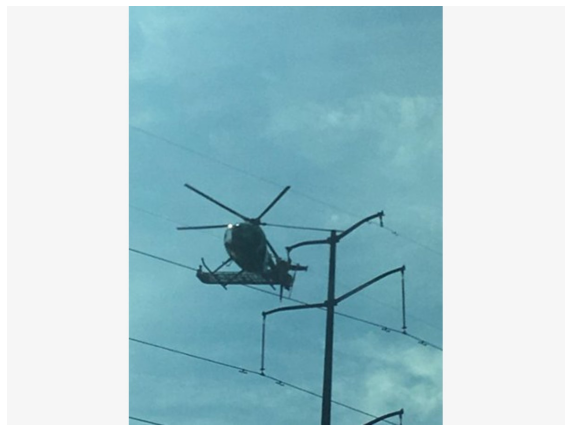

In [101]:
img_path=os.path.join(test_helicopter_dir,'00000692.jpg')
img =image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 625.5, 351.5, -0.5)

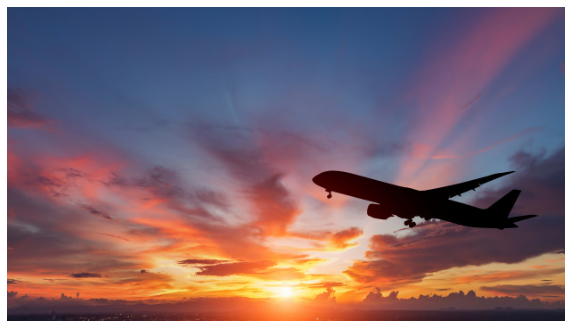

In [102]:
img_path=os.path.join(test_passenger_dir,'00001225.jpg')
img=image.load_img(img_path)

plt.figure(figsize=(10,10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)